# Predicting Bicycle Traffic

In this exercise, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

In this section, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.
Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (we use station ID USW00024233) and we can easily use Pandas to join the two data sources.
We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning.

Your task in this exercise is to fill in all the necessary parts in the code blocks (with "YOUR CODE HERE") to make the whole machine learning process complete.

Let's start:

First, we need to prepare the dataset, in this exercise, we need two .csv files as the data source.

You can download the first one from the following link:

https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

and save it as "FremontBridge.csv". The second file is prepared for you, you can download the "BicycleWeather.csv" file from iSpace.


After downloading the data, you can read the content of the files into pandas dataframe.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression

In [13]:

# we need to specify the index_col as the 'Date' column in each file, so that we can join them easily later

counts = pd.read_csv('../lecture_notes/Data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('../lecture_notes/Data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

You can have a look at each table of data

In the counts dataframe, the index is Date, where each hour's data is recorded from 2012-3-10 to 2019-3-31(depends on when you download the file). "Fremont Bridge East Sidewalk" column record the number of bicycles going through the east sidewalk of the bridge during each particular hour. Similar to "Fremont Bridge West Sidewalk".

In [3]:
counts.head(5)

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2019-03-31 23:00:00,6.0,10.0
2019-03-31 22:00:00,7.0,14.0
2019-03-31 21:00:00,18.0,15.0
2019-03-31 20:00:00,26.0,31.0
2019-03-31 19:00:00,30.0,58.0


In the weather dataframe, the index is "DATE" by each day from 2012-1-1 to 2015-9-1, the columns we are interested in includes "PRCP" (precipitation), "TMAX" and "TMIN" (max and min temperature during one day) etc.

In [4]:
weather.head(5)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

We need to sum up the hourly date together within each to get the total daily bicycle traffic.

After we get the daily bicycle traffic data, we can remove the other data (east and west) from the dataframe, keep the total daily data only.

In [5]:
#Pandas has a simple, powerful, and efficient functionality for performing resampling operations during frequency conversion 
#(e.g., converting hourly data to daily data). This is extremely common in, but not limited to, financial applications.

#resample() is a time-based groupby, followed by a reduction method on each of its groups. 

# resample the hourly data into daily data by sum up hourly data with each day
daily = counts.resample('d').sum()
#print(daily)



In [6]:
# add a column called 'Total' the the 'daily' dataframe, where the value of each row in 'Total' equal to the sum of both west and east

# YOUR CODE HERE

daily['Total'] = daily.sum(axis=1)
#print(daily)


In [7]:
#remove all other columns except the 'Total' column in 'daily' dataframe
daily = daily[['Total']] # remove other columns

Looking into the data carefully, you may find that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [10]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# make seven new columns named from 'Mon' to 'Sun'
# for each row, check the index 'Date', if the date is 'Mon', the value for 'Mon' of that date should be 1.0, otherwise the value is '0.0'; similar for other days in week.
# make sure you convert bool value to int or float value in you dataframe using ".astype(int)" or "astype(float)" function

# YOUR CODE HERE
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

daily.head(7)

# after this block, you dataframe 'daily' should look like this: 

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012-10-08,3537.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-09,3501.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [11]:
# don't worry, python provides very easy way to add holidays to your table

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2019')
holiday = pd.Series(1, index=holidays, name='holiday')
# Join the 'daily' dataframe with the holiday series on their index
# Consider using daily.join(), look for the documents about pandas dataframe join function for details

daily = daily.join(holiday)
daily['holiday'].fillna(0, inplace=True)
daily.head(10)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-08,3537.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012-10-09,3501.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-10,3235.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-11,3047.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

(8, 17)

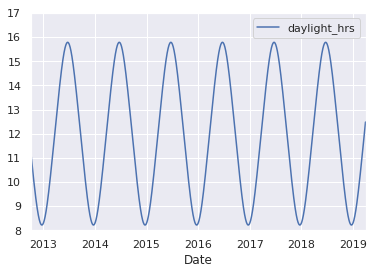

In [16]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    # calculates the hours of daylight
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))

# plt the daylight_hrs as the y-axis v.s. the date as the x-axis
# YOUR CODE HERE
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

# Your figure should look like this:

We can also add the average temperature and total precipitation to the data.
In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [17]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10

# compute the average of TMAX and TMIN, and put the value in a new column named 'Temp (c)' in 'weather' dataframe
# YOUR CODE HERE
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254

# make a new column named 'dry day' to indicate whether the day is dry or not
# we consider the day dry if the precipitation is equal to 0
# make sure you convert bool value to int or float value in you dataframe using ".astype(int)" or "astype(float)" function

# YOUR CODE HERE
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

daily.head(5)

# Now, the 'daily' dataframe should look like this:

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


Finally, let's add a counter that increases from day 1, and measures how many years have passed.
This will let us measure any observed annual increase or decrease in daily crossings:

In [18]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [19]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data.
We will set ``fit_intercept = False``, because the daily flags essentially operate as their own day-specific intercepts:

In [22]:
# Drop any ROWS with null values
# You can use dropna() function

# YOUR CODE HERE
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']

# make the training set, use all the data as training set

# YOUR CODE HERE

X = daily[column_names]
y = daily['Total']

# use the LinearRegression model, set the fit_intercept argument as False
# YOUR CODE HERE
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

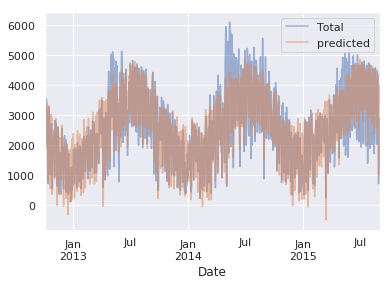

In [23]:
daily[['Total', 'predicted']].plot(alpha=0.5);


# Congratulations, if everything is correct, you should see a figure looks like this:

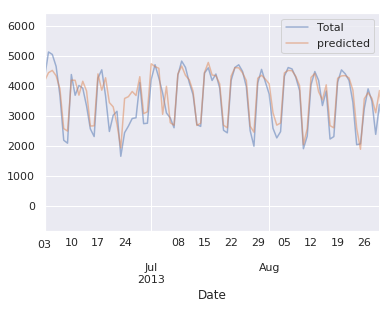

In [24]:
# Plot a figure of 'Total' and 'predicted' value similar to the above, but only covering from '2014-6-03' to '2014-8-30'

# YOUR CODE HERE
daily[['Total', 'predicted']].plot(xlim=('2013-6-03','2013-8-30'),alpha=0.5);

# The figure should look like this:

The mismatch indicates that either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [94]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty.
We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [97]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(100)], 0)

With these errors estimated, let's again look at the results:

In [98]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            505.0   81.0
Tue            610.0   85.0
Wed            593.0   76.0
Thu            482.0   80.0
Fri            178.0   74.0
Sat          -1103.0   74.0
Sun          -1134.0   75.0
holiday      -1187.0  159.0
daylight_hrs   129.0    8.0
PRCP          -665.0   66.0
dry day        548.0   34.0
Temp (C)        65.0    4.0
annual          27.0   17.0


We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays.
We see that for each additional hour of daylight, 129 ± 8 more people choose to ride; a temperature increase of one degree Celsius encourages 65 ± 4 people to grab their bicycle; a dry day means an average of 548 ± 34 more riders, and each inch of precipitation means 665 ± 66 more people leave their bike at home.
Once all these effects are accounted for, we see a modest increase of 27 ± 17 new daily riders each year.

Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model.
Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).
These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!